In [1]:
from abipy.core.structure import Structure as AbiStructure
from pymatgen.core.structure import Structure
from copy import deepcopy
from matplotlib import pyplot as plt
from modnet.hyper_opt.fit_genetic import FitGenetic
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from monty.serialization import dumpfn, loadfn
from optimade.adapters.structures import Structure as OptimadeStructure
from optimade.adapters.structures.pymatgen import get_pymatgen
from pathlib import Path
from plotly.subplots import make_subplots
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from scipy.stats import gaussian_kde, spearmanr
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold

import json
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import math
import modnet.featurizers.presets.matminer_2024_fast as fastfeat
import pandas as pd
import plotly.graph_objs as go

2025-01-05 15:48:16.450976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 15:48:16.536994: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 15:48:16.540426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2025-01-05 15:48:16.540445: I tensorflow/compiler/xla/stream_execut

In [2]:
cur_v = int(Path(os.getcwd()).parent.name.split("_")[0])
print(cur_v)

19


# Load pred search space

In [3]:
path_df_full_pred = "../data/df_full_pred.pkl.gz"
df_full_pred = pd.read_pickle(path_df_full_pred)

print(f"{df_full_pred.shape = }")
display(df_full_pred.head())

df_full_pred.shape = (31124, 4)


,dKP,dKP_unc,dKP_unc_cal_ma,dKP_unc_cal_nll
mp-759792,1.331904,0.386815,0.563414,8.338441
mp-660503,5.468415,3.766065,5.485450,81.183861
mp-34982,32.413658,15.832521,23.060810,341.296600
mp-1229155,7.266753,3.507335,5.108597,75.606491
mp-1229187,103.444359,21.803894,31.758394,470.019592


# Load data search space

In [4]:
# Load the std data of the full search space and filter it for the predicted search space
path_df_full_std = "../../../00_prepa_dbs/full_search_space/data/df_full_std.pkl.gz"
df_full_std = pd.read_pickle(path_df_full_std).filter(df_full_pred.index, axis=0)
print(f"{df_full_std.shape = }")
display(df_full_std.head())

df_full_std.shape = (31124, 6)


,structure,nsites,ehull,bandgap,spg,reduced_formula
mp-759792,"{'@module': 'pymatgen.core.structure', '@class...",92,0.011548,2.8580,1,Ag2B8O13
mp-660503,"{'@module': 'pymatgen.core.structure', '@class...",14,0.030593,1.3210,1,Ag2SO4
mp-34982,"{'@module': 'pymatgen.core.structure', '@class...",6,0.041563,0.3932,1,Ag3AuS2
mp-1229155,"{'@module': 'pymatgen.core.structure', '@class...",16,0.000000,1.5994,1,Ag4Hg4S4BrCl3
mp-1229187,"{'@module': 'pymatgen.core.structure', '@class...",18,0.017305,0.4035,1,Ag4Sn2(HgSe3)3


In [5]:
print(f"{df_full_pred.shape = }")
df_full_pred = pd.concat([df_full_pred, df_full_std], axis=1)
print(f"{df_full_pred.shape = }")
display(df_full_pred.head())

df_full_pred.shape = (31124, 4)
df_full_pred.shape = (31124, 10)


,dKP,dKP_unc,dKP_unc_cal_ma,dKP_unc_cal_nll,structure,nsites,ehull,bandgap,spg,reduced_formula
mp-759792,1.331904,0.386815,0.563414,8.338441,"{'@module': 'pymatgen.core.structure', '@class...",92,0.011548,2.8580,1,Ag2B8O13
mp-660503,5.468415,3.766065,5.485450,81.183861,"{'@module': 'pymatgen.core.structure', '@class...",14,0.030593,1.3210,1,Ag2SO4
mp-34982,32.413658,15.832521,23.060810,341.296600,"{'@module': 'pymatgen.core.structure', '@class...",6,0.041563,0.3932,1,Ag3AuS2
mp-1229155,7.266753,3.507335,5.108597,75.606491,"{'@module': 'pymatgen.core.structure', '@class...",16,0.000000,1.5994,1,Ag4Hg4S4BrCl3
mp-1229187,103.444359,21.803894,31.758394,470.019592,"{'@module': 'pymatgen.core.structure', '@class...",18,0.017305,0.4035,1,Ag4Sn2(HgSe3)3


# Select

## Remove previously selected

In [6]:
pred_cur_v = np.arange(14,cur_v)
paths_df_prev_selected = [f"../../{v}_al_it/data/df_selected_v{v}.pkl.gz" for v in pred_cur_v]
df_prev_selected = pd.concat([pd.read_pickle(path) for path in paths_df_prev_selected], axis=0)
print(f"{df_prev_selected.shape =}")
print(f"{df_full_pred.shape =}")
df_full_pred = df_full_pred.drop(df_prev_selected.index, axis=0, errors='ignore')
print(f"{df_full_pred.shape =}")

df_prev_selected.shape =(1772, 11)
df_full_pred.shape =(31124, 10)
df_full_pred.shape =(30271, 10)


## from nsites

In [7]:
df_selected_tmp = df_full_pred[df_full_pred['nsites']<=50]
# df_selected_tmp = df_selected_tmp[df_selected_tmp['bandgap']>=0.5]

print(f"{df_full_pred.shape[0] = }")
print(f"{df_selected_tmp.shape[0] = }")

df_full_pred.shape[0] = 30271
df_selected_tmp.shape[0] = 26313


## from Pareto

In [8]:
def get_pareto_front(Xs=None, Ys=None, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY) # sorts the pairs wrt X descending (highest first) and then only Y descending
    pareto_front = [sorted_list[0]] # saves the highest X with highest Y ("last point")
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]: # if Y higher than the last saved point (X is lower anyway), saves this point
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    # '''Plotting process'''
    # plt.scatter(Xs,Ys,marker='.')
    # pf_X = [pair[0] for pair in pareto_front]
    # pf_Y = [pair[1] for pair in pareto_front]
    # plt.scatter(pf_X, pf_Y,color='red',marker='.')
    # plt.xlabel("Objective 1")
    # plt.ylabel("Objective 2")
    # plt.show()

    return pareto_front

def peel_pareto_fronts(nb_fronts, df_entries, X_name, Y_name, Y_unc_name=None, coef_unc=1):
    df_pareto = pd.DataFrame(columns=df_entries.columns)
    df_wo_pareto = deepcopy(df_entries)

    for i in range(nb_fronts):
        Xs = df_wo_pareto[X_name].tolist()
        if Y_unc_name:
            Ys = df_wo_pareto[Y_name]+df_wo_pareto[Y_unc_name]*coef_unc
            Ys = Ys.tolist()
        else:
            Ys = df_wo_pareto[Y_name].tolist()

        pareto_front = get_pareto_front(Xs=Xs, Ys=Ys)
        df_pareto_new = pd.DataFrame(columns=df_entries.columns)

        for xs, ys in pareto_front:
            if Y_unc_name:
                df_match = df_entries[(df_entries[X_name]==xs) & (df_entries[Y_name]+df_entries[Y_unc_name]*coef_unc==ys)]
            else:
                df_match = df_entries[(df_entries[X_name]==xs) & (df_entries[Y_name]==ys)]
            if len(df_match) > 1:
                print("There are multiple occurences of the same bandgap")
            df_pareto_new = pd.concat([df_pareto_new.astype(df_match.dtypes), df_match])
        df_pareto = pd.concat([df_pareto.astype(df_match.dtypes), df_pareto_new])
        # df_pareto = df_pareto.reset_index(drop=True)
        # display(df_pareto)
    
        df_wo_pareto = df_wo_pareto.drop(df_pareto_new.index, axis=0)

    return df_pareto, df_wo_pareto


    # df_wo_pareto = pd.concat([df,df_pareto], ignore_index=True).drop_duplicates(subset=['mp_id'], keep=False, ignore_index=True)

    # print(f"Number of selected instances = {len(pareto_front)}")

In [11]:
nb_pareto_peeled = 2

Select the Pareto front
df_selected_tmp.shape = (26313, 10)
(194, 10)
(120, 10)
(74, 10)
(26119, 10)


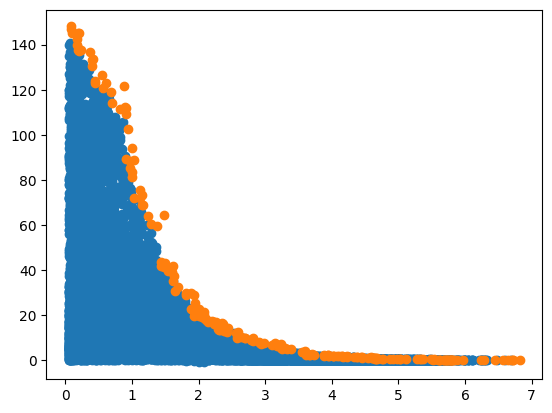

Select the Pareto front of target + unc
df_selected_tmp.shape = (26313, 10)
(183, 10)
(114, 10)
(69, 10)
(26130, 10)


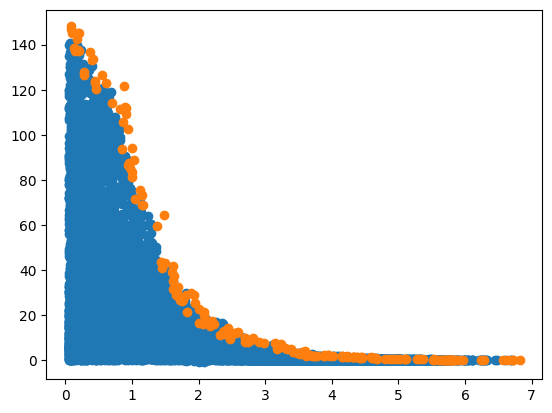

Select the Pareto front of target - unc
df_selected_tmp.shape = (26313, 10)
(193, 10)
(131, 10)
(62, 10)
(26120, 10)


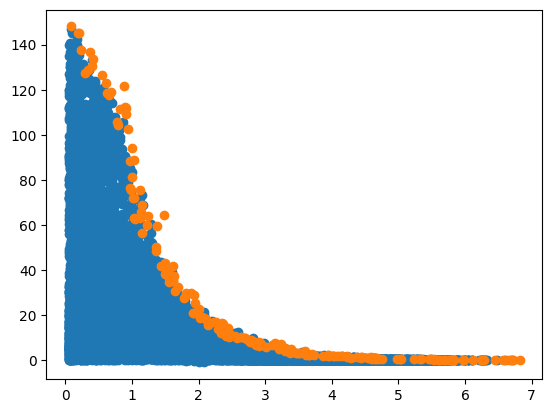

Select the Pareto front of target + unc_cal_ma
df_selected_tmp.shape = (26313, 10)
(170, 10)
(108, 10)
(62, 10)
(26143, 10)


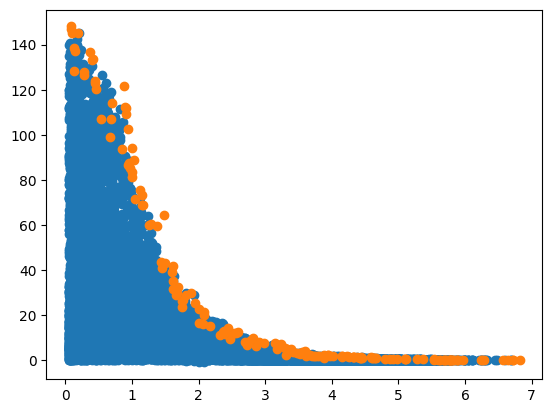

Select the Pareto front of target + unc_cal_nll
df_selected_tmp.shape = (26313, 10)
(145, 10)
(84, 10)
(61, 10)
(26168, 10)


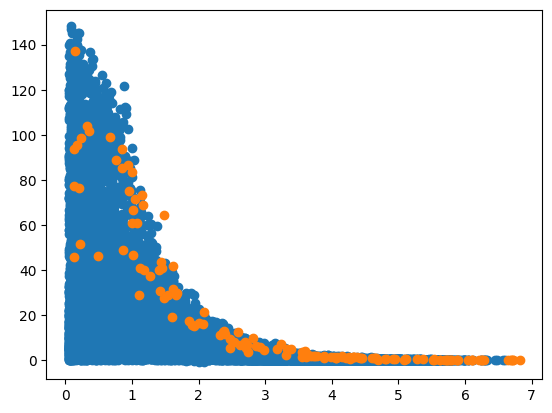

TOTAL
df_selected.shape = (386, 11)
(265, 11)
(121, 11)


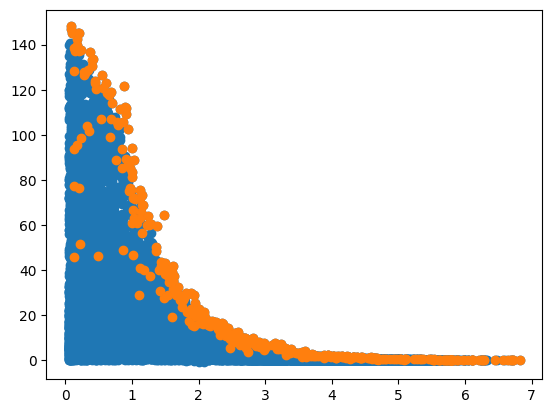

In [12]:
df_selected = pd.DataFrame()

# Select the Pareto front 
print("Select the Pareto front")
print(f"{df_selected_tmp.shape = }")
df_pareto, df_wo_pareto = peel_pareto_fronts(nb_pareto_peeled, df_selected_tmp, X_name='bandgap', Y_name='dKP')
print(df_pareto.shape)
print(df_pareto[df_pareto['bandgap']<=4].shape)
print(df_pareto[df_pareto['bandgap']>4].shape)
print(df_wo_pareto.shape)

df_pareto['added_from'] = ['Pareto']*len(df_pareto)
df_selected = pd.concat([df_selected, df_pareto.drop(df_selected.index, axis=0, errors='ignore')], axis=0)

plt.figure()
plt.scatter(df_wo_pareto['bandgap'], df_wo_pareto['dKP'])
plt.scatter(df_pareto['bandgap'], df_pareto['dKP'])
plt.show()



# Select the Pareto front of target+unc
print("Select the Pareto front of target + unc")
print(f"{df_selected_tmp.shape = }")
df_pareto, df_wo_pareto = peel_pareto_fronts(nb_pareto_peeled, df_selected_tmp, X_name='bandgap', Y_name='dKP', Y_unc_name='dKP_unc')
print(df_pareto.shape)
print(df_pareto[df_pareto['bandgap']<=4].shape)
print(df_pareto[df_pareto['bandgap']>4].shape)
print(df_wo_pareto.shape)

df_pareto['added_from'] = ['Pareto + unc']*len(df_pareto)
df_selected = pd.concat([df_selected, df_pareto.drop(df_selected.index, axis=0, errors='ignore')], axis=0)

plt.figure()
plt.scatter(df_wo_pareto['bandgap'], df_wo_pareto['dKP'])
plt.scatter(df_pareto['bandgap'], df_pareto['dKP'])
plt.show()


# Select the Pareto front of target-unc
print("Select the Pareto front of target - unc")
print(f"{df_selected_tmp.shape = }")
df_pareto, df_wo_pareto = peel_pareto_fronts(nb_pareto_peeled, df_selected_tmp, X_name='bandgap', Y_name='dKP', Y_unc_name='dKP_unc', coef_unc=-1)
print(df_pareto.shape)
print(df_pareto[df_pareto['bandgap']<=4].shape)
print(df_pareto[df_pareto['bandgap']>4].shape)
print(df_wo_pareto.shape)

df_pareto['added_from'] = ['Pareto - unc']*len(df_pareto)
df_selected = pd.concat([df_selected, df_pareto.drop(df_selected.index, axis=0, errors='ignore')], axis=0)

plt.figure()
plt.scatter(df_wo_pareto['bandgap'], df_wo_pareto['dKP'])
plt.scatter(df_pareto['bandgap'], df_pareto['dKP'])
plt.show()




# Select the Pareto front of target+unc_cal_ma
print("Select the Pareto front of target + unc_cal_ma")
print(f"{df_selected_tmp.shape = }")
df_pareto, df_wo_pareto = peel_pareto_fronts(nb_pareto_peeled, df_selected_tmp, X_name='bandgap', Y_name='dKP', Y_unc_name='dKP_unc_cal_ma')
print(df_pareto.shape)
print(df_pareto[df_pareto['bandgap']<=4].shape)
print(df_pareto[df_pareto['bandgap']>4].shape)
print(df_wo_pareto.shape)

df_pareto['added_from'] = ['Pareto + unc_cal_ma']*len(df_pareto)
df_selected = pd.concat([df_selected, df_pareto.drop(df_selected.index, axis=0, errors='ignore')], axis=0)

plt.figure()
plt.scatter(df_wo_pareto['bandgap'], df_wo_pareto['dKP'])
plt.scatter(df_pareto['bandgap'], df_pareto['dKP'])
plt.show()




# Select the Pareto front of target+unc_cal_nll
print("Select the Pareto front of target + unc_cal_nll")
print(f"{df_selected_tmp.shape = }")
df_pareto, df_wo_pareto = peel_pareto_fronts(nb_pareto_peeled, df_selected_tmp, X_name='bandgap', Y_name='dKP', Y_unc_name='dKP_unc_cal_nll')
print(df_pareto.shape)
print(df_pareto[df_pareto['bandgap']<=4].shape)
print(df_pareto[df_pareto['bandgap']>4].shape)
print(df_wo_pareto.shape)

df_pareto['added_from'] = ['Pareto + unc_cal_nll']*len(df_pareto)
df_selected = pd.concat([df_selected, df_pareto.drop(df_selected.index, axis=0, errors='ignore')], axis=0)

plt.figure()
plt.scatter(df_wo_pareto['bandgap'], df_wo_pareto['dKP'])
plt.scatter(df_pareto['bandgap'], df_pareto['dKP'])
plt.show()



print("TOTAL")
print(f"{df_selected.shape = }")
print(df_selected[df_selected['bandgap']<=4].shape)
print(df_selected[df_selected['bandgap']>4].shape)

plt.figure()
plt.scatter(df_selected_tmp['bandgap'], df_selected_tmp['dKP'])
plt.scatter(df_selected['bandgap'], df_selected['dKP'])
plt.show()

In [13]:
df_selected['added_from'].value_counts()

added_from
Pareto                  194
Pareto - unc             64
Pareto + unc_cal_nll     60
Pareto + unc             53
Pareto + unc_cal_ma      15
Name: count, dtype: int64

In [14]:
path_df_selected = f"../data/df_selected_v{cur_v}.pkl.gz"
if Path(path_df_selected).exists():
    df_selected = pd.read_pickle(path_df_selected)
else:
    df_selected.to_pickle(path_df_selected)